# Part One: Cleaning Data and Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
from xgboost import XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('raw_data/consolidado.csv')

In [3]:
# Select the desired columns
df = df[['date', 'price_soybean', 'real_interest_rate', 'SP500', 'SOYBEANS - USA PRODUCTION [mTons]']]

In [4]:
df = df.rename(columns={'SOYBEANS - USA PRODUCTION [mTons]': 'usa_prod'})

In [5]:
df.head()

date price_soybean  real_interest_rate  SP500  usa_prod
0   7/1/1988         787,5             4.43535  326.2    42.153
1   8/1/1988         867,5             4.54274  326.2    42.153
2   9/1/1988           813             4.70786  326.2    42.153
3  10/3/1988        789,25             4.46199  326.2    42.153
4  11/1/1988        763,75             4.35872  326.2    42.153

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
# Remove the year 2023
df = df[df['date'].dt.year != 2023]

In [8]:
# Select rows based on condition of date since 01-2005 
df = df.loc[(df['date'] >= '2005-01-01')]

In [9]:
# Choose 90% of the rows randomly 
df = df.sample(frac=0.9, random_state=42)

In [10]:
# Scale usa_prod and SP500 by minimum value
df['usa_prod'] = df['usa_prod'] / df['usa_prod'].min()
df['SP500'] = df['SP500'] / df['SP500'].min()

In [11]:
# Function to add labels in future soybean prices
# Reference: https://github.com/guptapiyush340/Soybean-Price-Prediction-Winning-solution-MinneAnalytics-Data-Science-Challenge/blob/master/XGBoost%20-%20Final%20Model.ipynb

def new_lags(data, lag_soybean_price, steps):
    ##Para 1 mes
    lag_col= ['price_soybean', 'real_interest_rate', 'SP500', 'usa_prod']
    t = 1
    data=data.assign(**{'{} (t-{})'.format(col, t): data[col].shift(+t) for col in lag_col})
    ##Para 3 y 6 meses
    lags = range(3, lag_soybean_price, steps)
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(+t)
        for t in lags
        for col in lag_col
    })
    
    
    return data

In [12]:
df = new_lags(df, lag_soybean_price = 7, steps = 3)
df.head(10)

date price_soybean  real_interest_rate     SP500  usa_prod  \
399 2021-10-01        1249,5             0.08790  4.421815  1.667989   
411 2022-10-03        1419,5             1.79733  4.187112  1.597291   
336 2016-07-01          1003             0.16535  2.774165  1.604908   
375 2019-10-01        932,25             0.36832  3.550990  1.326768   
213 2006-04-03           601             2.35839  2.075081  1.194101   
309 2014-04-01       1512,75             0.70222  2.560745  1.467286   
380 2020-03-02           886            -0.12784  2.793083  1.574946   
271 2011-02-01       1364,75             0.82969  1.857819  1.156906   
403 2022-02-01       1636,75             0.44159  4.418859  1.597291   
337 2016-08-01           943             0.22684  2.782737  1.604908   

    price_soybean (t-1)  real_interest_rate (t-1)  SP500 (t-1)  \
399                 NaN                       NaN          NaN   
411              1249,5                   0.08790     4.421815   
336              1419,5                   1.79733     4.187112   
375                1003                   0.16535     2.774165   
213              932,25                   0.36832     3.550990   
309                 601                   2.35839     2.075081   
380             1512,75                   0.70222     2.560745   
271                 886                  -0.12784     2.793083   
403             1364,75                   0.82969     1.857819   
337             1636,75                   0.44159     4.418859   

     usa_prod (t-1) price_soybean (t-3)  real_interest_rate (t-3)  \
399             NaN                 NaN                       NaN   
411        1.667989                 NaN                       NaN   
336        1.597291                 NaN                       NaN   
375        1.604908              1249,5                   0.08790   
213        1.326768              1419,5                   1.79733   
309        1.194101                1003                   0.16535   
380        1.467286              932,25                   0.36832   
271        1.574946                 601                   2.35839   
403        1.156906             1512,75                   0.70222   
337        1.597291                 886                  -0.12784   

     SP500 (t-3)  usa_prod (t-3) price_soybean (t-6)  \
399          NaN             NaN                 NaN   
411          NaN             NaN                 NaN   
336          NaN             NaN                 NaN   
375     4.421815        1.667989                 NaN   
213     4.187112        1.597291                 NaN   
309     2.774165        1.604908                 NaN   
380     3.550990        1.326768              1249,5   
271     2.075081        1.194101              1419,5   
403     2.560745        1.467286                1003   
337     2.793083        1.574946              932,25   

     real_interest_rate (t-6)  SP500 (t-6)  usa_prod (t-6)  
399                       NaN          NaN             NaN  
411                       NaN          NaN             NaN  
336                       NaN          NaN             NaN  
375                       NaN          NaN             NaN  
213                       NaN          NaN             NaN  
309                       NaN          NaN             NaN  
380                   0.08790     4.421815        1.667989  
271                   1.79733     4.187112        1.597291  
403                   0.16535     2.774165        1.604908  
337                   0.36832     3.550990        1.326768

In [13]:
print(df.columns)

Index(['date', 'price_soybean', 'real_interest_rate', 'SP500', 'usa_prod',
       'price_soybean (t-1)', 'real_interest_rate (t-1)', 'SP500 (t-1)',
       'usa_prod (t-1)', 'price_soybean (t-3)', 'real_interest_rate (t-3)',
       'SP500 (t-3)', 'usa_prod (t-3)', 'price_soybean (t-6)',
       'real_interest_rate (t-6)', 'SP500 (t-6)', 'usa_prod (t-6)'],
      dtype='object')


In [22]:
import pandas as pd

def get_dataframe_row(month, year, df):
    # filtrar dataframe basado en año y mes
    date = pd.to_datetime(f'{year}-{month:02d}-01')
    filtered_df = df[df['date'].dt.month == month]
    filtered_df = filtered_df[filtered_df['date'].dt.year == year]

    # te devuelve la fila del mes-año
    return filtered_df.iloc[0].to_numpy()


In [24]:
month = 8  # ejemplo de mes
year = 2022  # ejemplo del año

row = get_dataframe_row(month, year, df)
print(row)


[Timestamp('2022-08-01 00:00:00') '1422,5' 0.85563 4.113508720070943
 1.597290657296971 '1153,25' 0.5191 2.7044043748152524 1.6049081101854268
 '1199' 0.1461 1.7685486254803426 1.1363180938525097 '840,75' -0.02786
 3.19864026012415 1.5749461288241673]


In [17]:
import numpy as np
import pandas as pd

def get_dataframe_row(month, year, df):
    # Create a copy of the dataframe with selected columns
    selected_columns = ['date', 'price_soybean', 'real_interest_rate', 'SP500', 'usa_prod']
    df_selected = df[selected_columns].copy()

    # Set the date to the specified month and year
    date = pd.to_datetime(f'{year}-{month:02d}-01')
    df_selected['date'] = date

    # Set other columns to NaN for now
    columns = ['price_soybean (t-1)', 'real_interest_rate (t-1)', 'SP500 (t-1)', 'usa_prod (t-1)']
    for col in columns:
        df_selected[col] = np.nan

    # Fill in the values for columns with "t-1" in their names
    if month == 1:
        df_selected.loc[0, 'price_soybean (t-1)'] = 100  # Set a default value for the first month
    else:
        previous_month = month - 1
        previous_row = df[(df['year'] == year) & (df['month'] == previous_month)]
        df_selected.loc[0, 'price_soybean (t-1)'] = previous_row['price_soybean'].values[0]

    previous_year = year - 1
    previous_year_row = df[(df['year'] == previous_year) & (df['month'] == month)]
    df_selected.loc[0, 'usa_prod (t-1)'] = previous_year_row['usa_prod'].values[0]
    df_selected.loc[0, 'SP500 (t-1)'] = previous_year_row['SP500'].values[0]
    df_selected.loc[0, 'real_interest_rate (t-1)'] = previous_year_row['real_interest_rate'].values[0]

    return df_selected.values.flatten()


In [16]:
month = 7  # Example month
year = 2023  # Example year

row = get_dataframe_row(month, year, df)
print(row)


KeyError: 'year'

In [245]:
df.tail(10)

date  price_soybean  real_interest_rate     SP500  usa_prod  \
246 2009-01-01         980.00             0.93854  1.151345  1.255439   
286 2012-05-01        1340.00            -0.08722  1.742832  1.136318   
219 2006-10-02         644.25             2.21206  2.184452  1.194101   
255 2009-10-01         976.50             0.99714  1.437186  1.255439   
358 2018-05-01        1018.50             1.21609  3.198640  1.654085   
406 2022-05-02        1683.25             1.20390  4.372746  1.597291   
385 2020-08-03         953.50            -0.40713  3.379545  1.574946   
327 2015-10-01         885.75             0.52877  2.625776  1.466792   
235 2008-02-01        1536.50             1.11112  2.047591  1.108291   
355 2018-02-01        1055.50             1.08847  3.257168  1.654085   

     price_soybean (t-1)  real_interest_rate (t-1)  SP500 (t-1)  \
246              1060.50                   1.06141     1.519362   
286               980.00                   0.93854     1.151345   
219              1340.00                  -0.08722     1.742832   
255               644.25                   2.21206     2.184452   
358               976.50                   0.99714     1.437186   
406              1018.50                   1.21609     3.198640   
385              1683.25                   1.20390     4.372746   
327               953.50                  -0.40713     3.379545   
235               885.75                   0.52877     2.625776   
355              1536.50                   1.11112     2.047591   

     usa_prod (t-1)  price_soybean (t-3)  real_interest_rate (t-3)  \
246        1.255439              1364.75                   1.20425   
286        1.255439               910.25                   1.06818   
219        1.136318              1060.50                   1.06141   
255        1.194101               980.00                   0.93854   
358        1.255439              1340.00                  -0.08722   
406        1.654085               644.25                   2.21206   
385        1.597291               976.50                   0.99714   
327        1.574946              1018.50                   1.21609   
235        1.466792              1683.25                   1.20390   
355        1.108291               953.50                  -0.40713   

     SP500 (t-3)  usa_prod (t-3)  price_soybean (t-6)  \
246     3.760863        1.597291              1292.50   
286     3.262489        1.326768               952.00   
219     1.519362        1.255439               881.50   
255     1.151345        1.255439              1364.75   
358     1.742832        1.136318               910.25   
406     2.184452        1.194101              1060.50   
385     1.437186        1.255439               980.00   
327     3.198640        1.654085              1340.00   
235     4.372746        1.597291               644.25   
355     3.379545        1.574946               976.50   

     real_interest_rate (t-6)  SP500 (t-6)  usa_prod (t-6)  
246                   0.41830     2.489802        1.253970  
286                   1.25074     1.091339        1.255439  
219                   0.44057     3.450192        1.326768  
255                   1.20425     3.760863        1.597291  
358                   1.06818     3.262489        1.326768  
406                   1.06141     1.519362        1.255439  
385                   0.93854     1.151345        1.255439  
327                  -0.08722     1.742832        1.136318  
235                   2.21206     2.184452        1.194101  
355                   0.99714     1.437186        1.255439

In [14]:
# Scale soybean prices for 1, 3 and 6 months
df['price_soybean (t-1)'] = df['price_soybean (t-1)'] / df['price_soybean (t-1)'].min()
df['price_soybean (t-3)'] = df['price_soybean (t-3)'] / df['price_soybean (t-3)'].min()
df['price_soybean (t-6)'] = df['price_soybean (t-6)'] / df['price_soybean (t-6)'].min()

TypeError: '<=' not supported between instances of 'float' and 'str'

In [ ]:
# Extract month and year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [248]:
# Create cyclic features using sine and cosine transformations
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
#df['year_sin'] = np.sin(2 * np.pi * df['year'] / df['year'].max())
#df['year_cos'] = np.cos(2 * np.pi * df['year'] / df['year'].max())

In [249]:
df = df.drop(columns=['date', 'month'], axis=1)

In [250]:
# Fill null values with rolling median and backfill remaining nulls
rolling_median = df.rolling(window=36, min_periods=1).median()
df_filled = df.fillna(rolling_median)
df = df_filled.fillna(method='bfill')

In [176]:
#selected_columns = [df.columns.tolist()[i] for i in range(1, df.shape[1])]

In [113]:
# Scale selected columns using MinMaxScaler
#scaler = MinMaxScaler()
#df[selected_columns] = scaler.fit_transform(df[selected_columns])

In [251]:
# Check for any remaining null values
num_null_rows = df.isnull().sum(axis=1).sum()
num_null_rows

0

In [252]:
df

price_soybean  real_interest_rate     SP500  usa_prod  \
399        1249.50             0.08790  4.421815  1.667989   
411        1419.50             1.79733  4.187112  1.597291   
336        1003.00             0.16535  2.774165  1.604908   
375         932.25             0.36832  3.550990  1.326768   
213         601.00             2.35839  2.075081  1.194101   
..             ...                 ...       ...       ...   
406        1683.25             1.20390  4.372746  1.597291   
385         953.50            -0.40713  3.379545  1.574946   
327         885.75             0.52877  2.625776  1.466792   
235        1536.50             1.11112  2.047591  1.108291   
355        1055.50             1.08847  3.257168  1.654085   

     price_soybean (t-1)  real_interest_rate (t-1)  SP500 (t-1)  \
399             2.427392                   0.08790     4.421815   
411             2.427392                   0.08790     4.421815   
336             2.757649                   1.79733     4.187112   
375             1.948519                   0.16535     2.774165   
213             1.811073                   0.36832     3.550990   
..                   ...                       ...          ...   
406             1.978630                   1.21609     3.198640   
385             3.270034                   1.20390     4.372746   
327             1.852356                  -0.40713     3.379545   
235             1.720738                   0.52877     2.625776   
355             2.984944                   1.11112     2.047591   

     usa_prod (t-1)  price_soybean (t-3)  real_interest_rate (t-3)  \
399        1.667989             2.427392                   0.08790   
411        1.667989             2.427392                   0.08790   
336        1.597291             2.427392                   0.08790   
375        1.604908             2.427392                   0.08790   
213        1.326768             2.757649                   1.79733   
..              ...                  ...                       ...   
406        1.654085             1.251578                   2.21206   
385        1.597291             1.897037                   0.99714   
327        1.574946             1.978630                   1.21609   
235        1.466792             3.270034                   1.20390   
355        1.108291             1.852356                  -0.40713   

     SP500 (t-3)  usa_prod (t-3)  price_soybean (t-6)  \
399     4.421815        1.667989             2.427392   
411     4.421815        1.667989             2.427392   
336     4.421815        1.667989             2.427392   
375     4.421815        1.667989             2.427392   
213     4.187112        1.597291             2.427392   
..           ...             ...                  ...   
406     2.184452        1.194101             2.060223   
385     1.437186        1.255439             1.903837   
327     3.198640        1.654085             2.603205   
235     4.372746        1.597291             1.251578   
355     3.379545        1.574946             1.897037   

     real_interest_rate (t-6)  SP500 (t-6)  usa_prod (t-6)  year  month_sin  \
399                   0.08790     4.421815        1.667989  2021  -0.866025   
411                   0.08790     4.421815        1.667989  2022  -0.866025   
336                   0.08790     4.421815        1.667989  2016  -0.500000   
375                   0.08790     4.421815        1.667989  2019  -0.866025   
213                   0.08790     4.421815        1.667989  2006   0.866025   
..                        ...          ...             ...   ...        ...   
406                   1.06141     1.519362        1.255439  2022   0.500000   
385                   0.93854     1.151345        1.255439  2020  -0.866025   
327                  -0.08722     1.742832        1.136318  2015  -0.866025   
235                   2.21206     2.184452        1.194101  2008   0.866025   
355                   0.99714     1.437186        1.255439  

## XGBoost Model for 1 Month

In [253]:
y = df['price_soybean']
X = df[['price_soybean (t-1)', 'real_interest_rate (t-1)', 'SP500 (t-1)', 'usa_prod (t-1)', 
        'year', 'month_sin', 'month_cos']]

In [254]:
X

price_soybean (t-1)  real_interest_rate (t-1)  SP500 (t-1)  \
399             2.427392                   0.08790     4.421815   
411             2.427392                   0.08790     4.421815   
336             2.757649                   1.79733     4.187112   
375             1.948519                   0.16535     2.774165   
213             1.811073                   0.36832     3.550990   
..                   ...                       ...          ...   
406             1.978630                   1.21609     3.198640   
385             3.270034                   1.20390     4.372746   
327             1.852356                  -0.40713     3.379545   
235             1.720738                   0.52877     2.625776   
355             2.984944                   1.11112     2.047591   

     usa_prod (t-1)  year  month_sin  month_cos  
399        1.667989  2021  -0.866025   0.500000  
411        1.667989  2022  -0.866025   0.500000  
336        1.597291  2016  -0.500000  -0.866025  
375        1.604908  2019  -0.866025   0.500000  
213        1.326768  2006   0.866025  -0.500000  
..              ...   ...        ...        ...  
406        1.654085  2022   0.500000  -0.866025  
385        1.597291  2020  -0.866025  -0.500000  
327        1.574946  2015  -0.866025   0.500000  
235        1.466792  2008   0.866025   0.500000  
355        1.108291  2018   0.866025   0.500000  

[194 rows x 7 columns]

In [255]:
y_log = np.log(y)

In [256]:
#X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y,test_size=0.3,random_state=42)
X_train, X_test, y_train_log, y_test_log = train_test_split(X,y_log,test_size=0.3,random_state=42)

In [257]:
# Instanciate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)

In [121]:
#pipe_xgb = make_pipeline(model_xgb)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
mape = make_scorer(lambda y_true, y_pred: mean_absolute_percentage_error(y_true, y_pred))

cross_val_score(model_xgb,X,y,cv=5,scoring=mape,n_jobs=-1).mean()

0.07909987106575707

In [122]:
cross_val_score(model_xgb,X,y_log,cv=5,scoring=mape,n_jobs=-1).mean()

0.011689224407717237

MAPE Scores with New Scaling 

In [258]:
#pipe_xgb = make_pipeline(model_xgb)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
mape = make_scorer(lambda y_true, y_pred: mean_absolute_percentage_error(y_true, y_pred))

cross_val_score(model_xgb,X,y,cv=5,scoring=mape,n_jobs=-1).mean()

0.10707988856497912

In [259]:
cross_val_score(model_xgb,X,y_log,cv=5,scoring=mape,n_jobs=-1).mean()

0.01545405838556294

In [225]:
model_xgb.fit(X_train, y_train_log,
        verbose=False,
        eval_set=[(X_train, y_train_log)],
        eval_metric=["mape"],
        early_stopping_rounds=10)

/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [226]:
Results = {}
Results['y_predict_1'] = np.exp(model_xgb.predict(X_test))

In [227]:
Results['y_test_1'] = np.exp(y_test_log)

In [228]:
Results['year'] = X_test['year']

In [229]:
results = pd.DataFrame.from_dict(Results)
results

y_predict_1  y_test_1  year
399  1243.348755   1249.50  2021
411  1350.584106   1419.50  2022
336  1109.674805   1003.00  2016
375   897.691223    932.25  2019
213   588.621765    601.00  2006
309  1458.869995   1512.75  2014
380   889.110718    886.00  2020
271  1399.171021   1364.75  2011
403  1423.343750   1636.75  2022
337   996.275818    943.00  2016
357  1001.215332   1048.50  2018
228   944.953125    857.50  2007
388  1111.927002   1168.50  2020
207   581.627625    576.00  2005
265   925.699158   1010.00  2010
374   890.464905    906.00  2019
370   898.579407    877.75  2019
216   644.887695    599.75  2006
352   985.036011    985.75  2017
264   908.382446   1005.00  2010
384   919.614075    892.50  2020
340  1015.339050   1032.25  2016
277  1363.399780   1457.50  2011
223   713.128845    787.50  2007
302  1337.829712   1282.75  2013
344   980.917419    946.00  2017
359   987.837585    880.00  2018
214   612.105347    579.50  2006
243   954.403320    933.00  2008
397  1343.877441   1292.50  2021
306  1345.601685   1282.75  2014
253   980.777588    979.50  2009
310  1277.336182   1493.25  2014
390  1382.566284   1370.00  2021
322   993.737549    934.00  2015
326   875.335388    892.00  2015
273  1414.344849   1394.00  2011
333   925.281128   1029.75  2016
316   976.818359   1016.00  2014
296  1452.192627   1404.75  2013
294  1474.858154   1468.50  2013
382   915.629272    840.75  2020
315   897.828186   1049.25  2014
291  1606.624634   1548.75  2012

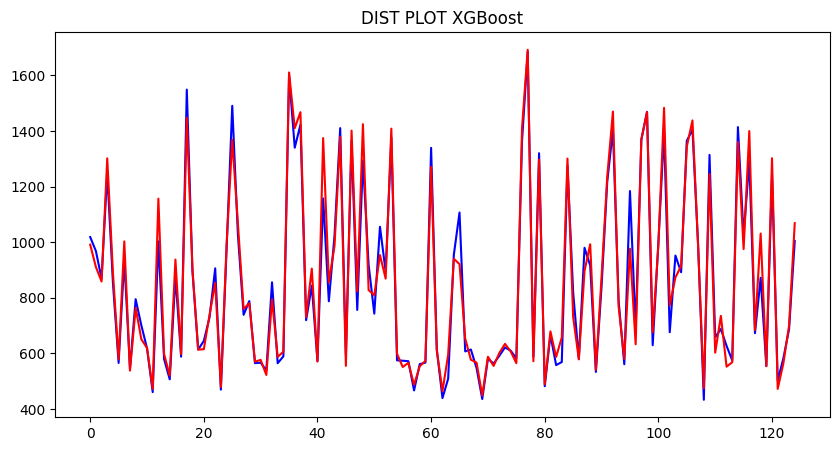

In [129]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(Results['y_test_1'])), Results['y_test_1'], 'b',label='Actual')
ax.plot(range(len(Results['y_predict_1'])), Results['y_predict_1'], 'r', label='Predicted')
plt.title('DIST PLOT XGBoost')
plt.xlabel('')
plt.ylabel('')
plt.show()

## XGBoost Model for 3 and 6 months

In [130]:
data_copy = df.copy()
data_copy

price_soybean  real_interest_rate     SP500  usa_prod  \
0           787.50            0.899947  0.000000  0.000000   
1           867.50            0.919905  0.000000  0.000000   
2           813.00            0.950591  0.000000  0.000000   
3           789.25            0.904898  0.000000  0.000000   
4           763.75            0.885706  0.000000  0.000000   
..             ...                 ...       ...       ...   
409        1422.50            0.234677  0.878391  0.935106   
410        1364.75            0.299466  0.780031  0.935106   
411        1419.50            0.409686  0.898920  0.935106   
412        1469.50            0.434474  0.920851  0.935106   
413        1524.00            0.368577  0.920851  0.935106   

     price_soybean (t-1)  real_interest_rate (t-1)  SP500 (t-1)  \
0               0.272249                  0.899947     0.000000   
1               0.272249                  0.899947     0.000000   
2               0.332332                  0.919905     0.000000   
3               0.291401                  0.950591     0.000000   
4               0.273564                  0.904898     0.000000   
..                   ...                       ...          ...   
409             0.783703                  0.273061     0.915739   
410             0.749155                  0.234677     0.878391   
411             0.705783                  0.299466     0.780031   
412             0.746902                  0.409686     0.898920   
413             0.784454                  0.434474     0.920851   

     usa_prod (t-1)  price_soybean (t-3)  real_interest_rate (t-3)  ...  \
0          0.000000             0.272249                  0.899947  ...   
1          0.000000             0.272249                  0.899947  ...   
2          0.000000             0.272249                  0.899947  ...   
3          0.000000             0.272249                  0.899947  ...   
4          0.000000             0.332332                  0.919905  ...   
..              ...                  ...                       ...  ...   
409        0.935106             0.944987                  0.299401  ...   
410        0.935106             0.775817                  0.266170  ...   
411        0.935106             0.783703                  0.273061  ...   
412        0.935106             0.749155                  0.234677  ...   
413        0.935106             0.705783                  0.299466  ...   

     price_soybean (t-6)  real_interest_rate (t-6)  SP500 (t-6)  \
0               0.272249                  0.899947     0.000000   
1               0.272249                  0.899947     0.000000   
2               0.272249                  0.899947     0.000000   
3               0.272249                  0.899947     0.000000   
4               0.272249                  0.899947     0.000000   
..                   ...                       ...          ...   
409             0.910064                  0.157730     0.963558   
410             0.896170                  0.140167     0.992332   
411             0.946113                  0.252103     0.930167   
412             0.944987                  0.299401     0.950697   
413             0.775817                  0.266170     0.850524   

     usa_prod (t-6)     month  year  month_sin  month_cos  year_sin  year_cos  
0          0.000000  0.545455   0.0   0.250000   0.066987       0.0       0.0  
1          0.000000  0.636364   0.0   0.066987   0.250000       0.0       0.0  
2          0.000000  0.727273   0.0   0.000000   0.500000       0.0       0.0  
3          0.000000  0.818182   0.0   0.066987   0.750000       0.0       0.0  
4          0.000000  0.909091   0.0   0.250000   0.933013       0.0       0.0  
..              ...       ...   ...        ...        ...       ...       ...  
409        0.935106  0.636364   1.0   0.066987   0.250000       1.0       1.0  
410        0.935106  0.727273   1.0   0.000000   0.500000       1.0       1.0  
411        0.935106  0.818182

In [133]:
Variables = {}
Scores = {}
Results = {}
#Selected_features = []
for iteration in range(3, 7, 3):
    data_copy = df.copy()
    #y_names.append('y_{}'.format('iteration'))
    Variables['y_{}'.format(iteration)] = np.log(data_copy['price_soybean'])
    Selected_features = [data_copy.columns.tolist()[i] for i in range(16, data_copy.shape[1])]
    Selected_features.append('{} (t-{})'.format('price_soybean', iteration))
    Selected_features.append('{} (t-{})'.format('real_interest_rate', iteration))
    Selected_features.append('{} (t-{})'.format('SP500', iteration))
    Selected_features.append('{} (t-{})'.format('usa_prod', iteration))
    Variables['X_{}'.format(iteration)] = data_copy[Selected_features]
    y_log = Variables['y_{}'.format(iteration)]
    X = Variables['X_{}'.format(iteration)]
    X_train, X_test, y_train_log, y_test_log = train_test_split(X,y_log,test_size=0.3,random_state=42)
    Scores['cross_val_score_{}'.format(iteration)] = cross_val_score(model_xgb,X,y_log,cv=5,scoring=mape,n_jobs=-1).mean()
    model_xgb.fit(X_train, y_train_log,
        verbose=False,
        eval_set=[(X_train, y_train_log)],
        eval_metric=["mape"],
        early_stopping_rounds=10)
    Results['y_predict_{}'.format(iteration)] = np.exp(model_xgb.predict(X_test))
    Results['y_test_{}'.format(iteration)] = np.exp(y_test_log)
    #print(y)
   

/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_

In [134]:
Scores

{'cross_val_score_3': 0.018812301788159326,
 'cross_val_score_6': 0.02583090534234389}

In [135]:
results = pd.DataFrame.from_dict(Results)
results

y_predict_3  y_test_3  y_predict_6  y_test_6
358   965.913757   1018.50   941.238464   1018.50
350   938.537415    968.25   948.816650    968.25
373   885.107788    869.00   888.077148    869.00
399  1366.040527   1249.50  1396.623413   1249.50
369   889.059326    854.00   924.471863    854.00
..           ...       ...          ...       ...
268  1185.489258   1243.00  1116.531616   1243.00
148   482.745300    502.00   482.529633    502.00
16    556.425964    582.75   678.324768    582.75
66    657.583740    686.75   674.228027    686.75
341   989.057434   1004.00  1027.203735   1004.00

[125 rows x 4 columns]

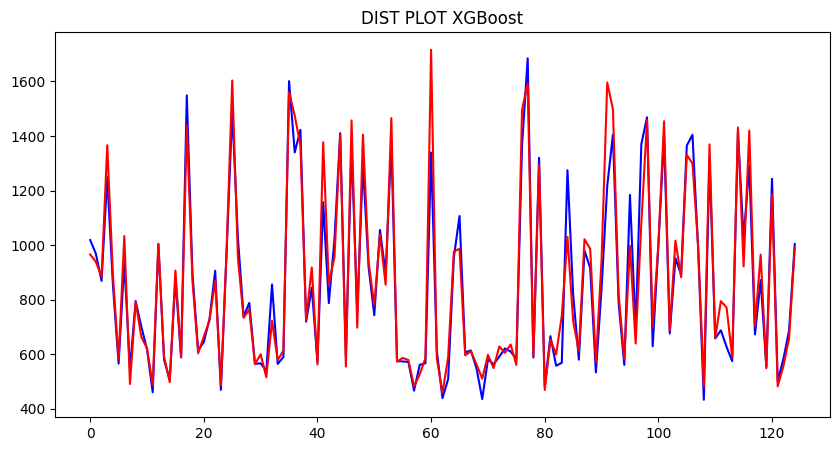

In [136]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(results['y_test_3'])), results['y_test_3'], 'b',label='Actual')
ax.plot(range(len(results['y_predict_3'])), results['y_predict_3'], 'r', label='Predicted')
plt.title('DIST PLOT XGBoost')
plt.xlabel('')
plt.ylabel('')
plt.show()

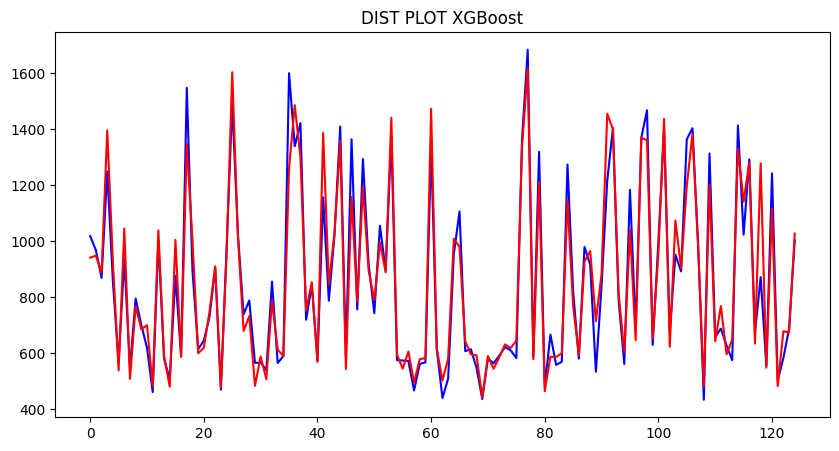

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(results['y_test_6'])), results['y_test_6'], 'b',label='Actual')
ax.plot(range(len(results['y_predict_6'])), results['y_predict_6'], 'r', label='Predicted')
plt.title('DIST PLOT XGBoost')
plt.xlabel('')
plt.ylabel('')
plt.show()